In [1]:
from urllib import request
import os
import json
import math
import urllib.parse as up
from helpers import tokenize_and_format, flat_accuracy
import torch
import pandas as pd

/home/miracle/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/miracle/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/miracle/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/miracle/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework

In [2]:
!pip install transformers==3.4.0
!pip install googletrans==3.1.0a0
!pip install celery==4.4.2
!pip install seqeval
!pip install conllu

     |████████████████████████████████| 1.3 MB 4.6 MB/s            
     |████████████████████████████████| 2.9 MB 29.9 MB/s            
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.5.2
    Uninstalling tokenizers-0.5.2:
      Successfully uninstalled tokenizers-0.5.2
  Attempting uninstall: transformers
    Found existing installation: transformers 2.8.0
    Uninstalling transformers-2.8.0:
      Successfully uninstalled transformers-2.8.0
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 55 kB 2.2 MB/s            
     |████████████████████████████████| 42 kB 2.0 MB/s             
     |████████████████████████████████| 1.3 MB 23.2 MB/s            
  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
     |████████████████████████████████| 58 kB 11.6 MB/s            
     |████████████████████████████████| 53 kB 2.9 MB/s              
     |████████████████████████████████| 65 kB 10.5 MB/s            
  Created 

In [37]:
df = pd.read_csv('transformer_citation_all_influ_nonzero.csv')
# df = pd.read_csv('transformer_citation_all_set.csv')
# df = pd.read_csv('tweets.csv')

df = df.sample(frac=1).reset_index(drop=True)

texts = df.text.values
# labels = df.citationCount.values
labels = df.influentialCitationCount_log.values


# labels =np.log(labels)/np.log(labels.max())

# print(labels)
### tokenize_and_format() is a helper function provided in helpers.py ###
input_ids, attention_masks = tokenize_and_format(texts)

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.FloatTensor(labels)
# Print sentence 0, now as a list of IDs.
print('Original: ', texts[0])
print('Token IDs:', input_ids[0])

Original:  GPT-3 achieves strong performance on many NLP datasets, including translation, question-answering, and cloze tasks, as well as several tasks that require on-the-fly reasoning or domain adaptation, such as unscrambling words, using a novel word in a sentence, or performing 3-digit arithmetic.
Token IDs: tensor([  101, 14246,  2102,  1011,  1017,  6162,  2015,  2844,  2836,  2006,
         2116, 17953,  2361,  2951, 13462,  2015,  1010,  2164,  5449,  1010,
         3160,  1011, 10739,  1010,  1998, 18856, 18153,  2063,  8518,  1010,
         2004,  2092,  2004,  2195,  8518,  2008,  5478,  2006,  1011,  1996,
         1011,  4875, 13384,  2030,  5884,  6789,  1010,  2107,  2004,  4895,
        11020,  6444,  9709,  2616,  1010,  2478,  1037,  3117,  2773,  1999,
         1037,  6251,  1010,   102])


In [50]:
input_ids.shape

torch.Size([3131, 64])

In [38]:
total = len(df)

num_train = int(total * .6)
num_val = int(total * .2)
num_test = total - num_train - num_val

# make lists of 3-tuples (already shuffled the dataframe in cell above)

train_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_train)]
val_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_train, num_val+num_train)]
test_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_val + num_train, total)]

train_text = [texts[i] for i in range(num_train)]
val_text = [texts[i] for i in range(num_train, num_val+num_train)]
test_text = [texts[i] for i in range(num_val + num_train, total)]

In [39]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 1, # The number of output labels.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [40]:
batch_size = 64
optimizer = AdamW(model.parameters(),
                  lr = 1e-4, # args.learning_rate - default is 5e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8
                  weight_decay = 0.01
                )
epochs = 25

In [41]:
import numpy as np
# function to get validation accuracy
def get_validation_performance(val_set):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    num_batches = int(len(val_set)/batch_size) + 1

    for i in range(num_batches):
      end_index = min(batch_size * (i+1), len(val_set))

      batch = val_set[i*batch_size:end_index]

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs[0]#.loss
        logits = outputs[1]#.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.cpu().detach().numpy()
        label_ids = b_labels.cpu().numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches. We provide a function in 
        # helpers.py called flat_accuracy() that takes in predictions and labels
        # acc = flat_accuracy(logits, label_ids)       
        # total_eval_accuracy += acc
        # print(logits,label_ids)
        error = np.abs(logits.T-label_ids).sum()
    # Report the final accuracy for this validation run.
    avg_error = error / num_batches
    return avg_error 



In [42]:
import random

# training loop
log_train_loss = np.zeros(epochs)
log_train_error = np.zeros(epochs)
# For each epoch...
best_err = 1e9
for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    # num_batches = int(len(train_set)/batch_size) + 1
    num_batches = int(len(train_set)/batch_size)

    for i in range(num_batches):
      end_index = min(batch_size * (i+1), len(train_set))

      batch = train_set[i*batch_size:end_index]
      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])

      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)

      # Clear the previously calculated gradient
      model.zero_grad()        

      # Perform a forward pass (evaluate the model on this training batch).
      outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            labels=b_labels)
      # print(outputs)
      loss = outputs[0]#.loss
      logits = outputs[1]#.logits

      total_train_loss += loss.item()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Update parameters and take a step using the computed gradient.
      optimizer.step()
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set. Implement this function in the cell above.
    total_train_loss /= (batch_size * num_batches)
    print(f"Total loss: {total_train_loss}")
    log_train_loss[epoch_i] = total_train_loss
    val_error = get_validation_performance(val_set)
    val_error /= batch_size
    log_train_error[epoch_i] = val_error
    print(f"Validation error: {val_error}")
    if val_error < best_err:
      best_model = model
    
# print("")
print("Training complete!")



======== Epoch 1 / 25 ========
Training...
Total loss: 0.006709882845010223
Validation error: 0.03685027658939362

======== Epoch 2 / 25 ========
Training...
Total loss: 0.0059481987504866616
Validation error: 0.035663163661956786

======== Epoch 3 / 25 ========
Training...
Total loss: 0.004861883714730884
Validation error: 0.030804917216300964

======== Epoch 4 / 25 ========
Training...
Total loss: 0.0039721866909029156
Validation error: 0.03181445598602295

======== Epoch 5 / 25 ========
Training...
Total loss: 0.0029181091331652014
Validation error: 0.03687785267829895

======== Epoch 6 / 25 ========
Training...
Total loss: 0.0033308818277999245
Validation error: 0.040510207414627075

======== Epoch 7 / 25 ========
Training...
Total loss: 0.0023327324507308417
Validation error: 0.041998907923698425

======== Epoch 8 / 25 ========
Training...
Total loss: 0.0022470532948600836
Validation error: 0.03190430998802185

======== Epoch 9 / 25 ========
Training...
Total loss: 0.001812120170

In [48]:
best_model.save_pretrained('results/pretrained_inf.ckpt')
# best_count_model = best_model

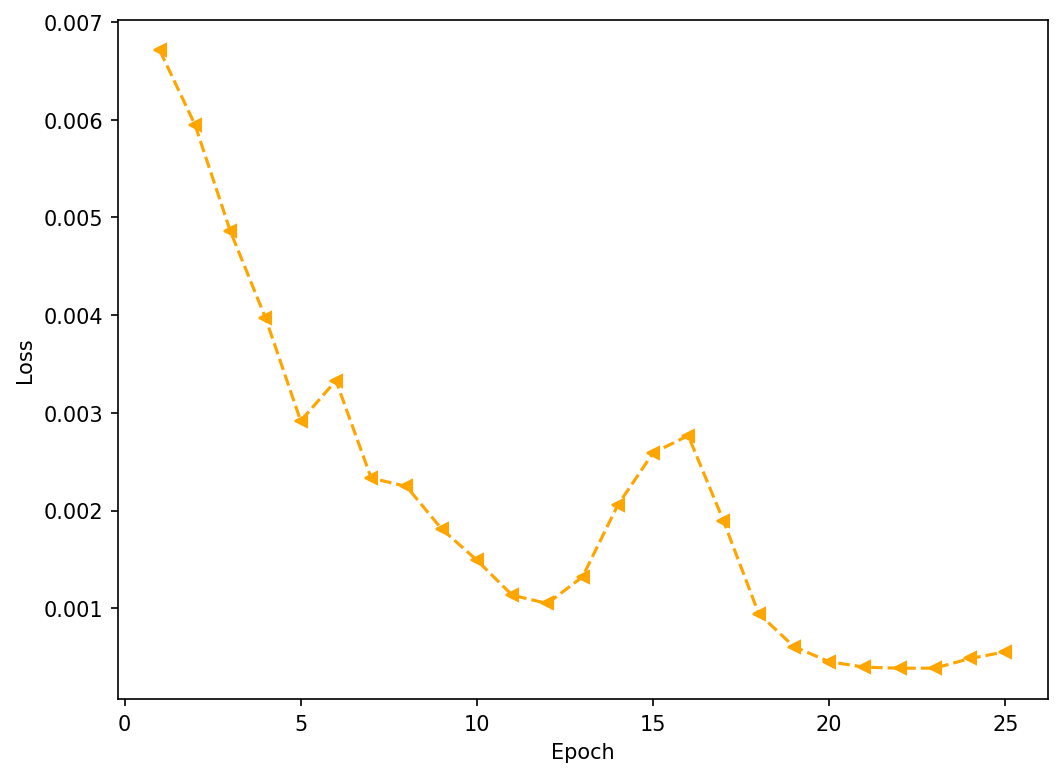

In [46]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(8,6), dpi=150)
x = np.arange(1,epochs+1)
# print(log_train_loss)
plt.plot(x,log_train_loss,linestyle='--',color='orange',marker='<')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('results/training_loss_inf.png')
plt.show()

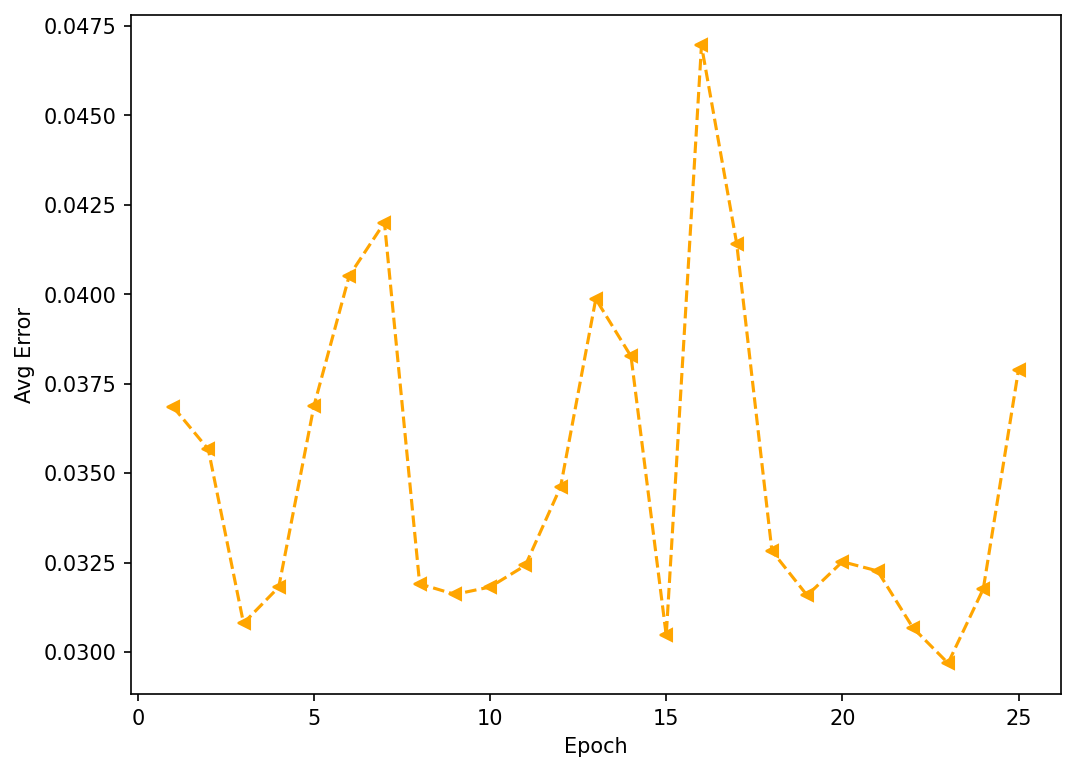

In [47]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,epochs+1)
# print(log_train_loss)
fig = plt.figure(figsize=(8,6), dpi=150)
plt.plot(x,log_train_error,linestyle='--',color='orange',marker='<')
plt.xlabel('Epoch')
plt.ylabel('Avg Error')
plt.savefig('results/val_avg_error_inf.png')
plt.show()

In [9]:
import numpy as np
# function to get validation accuracy
def get_test_performance(val_set):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    num_batches = int(len(val_set)/batch_size) + 1

    for i in range(num_batches):
      end_index = min(batch_size * (i+1), len(val_set))

      batch = val_set[i*batch_size:end_index]

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs[0]#.loss
        logits = outputs[1]#.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().numpy()
        label_ids = b_labels.numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches. We provide a function in 
        # helpers.py called flat_accuracy() that takes in predictions and labels
        # acc = flat_accuracy(logits, label_ids)       
        # total_eval_accuracy += acc
        # print(logits.T)
        # print(label_ids)
        print(np.abs(logits.T-label_ids).sum())
        error = np.abs(logits.T-label_ids).sum()
    # Report the final accuracy for this validation run.
    avg_error = error / num_batches
    return avg_error 

get_test_performance(val_set)

25.417408
45.786476
38.636177
36.503967


9.125991821289062

# TEST CASES

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")

In [64]:
df = pd.read_csv('transformer_citation_all_influ_nonzero_both.csv')
df = df.sample(frac=1).reset_index(drop=True)
texts = df.text.values

labels_ori = df.citationCount_log.values
labels_inf = df.influentialCitationCount_log.values

### tokenize_and_format() is a helper function provided in helpers.py ###
input_ids, attention_masks = tokenize_and_format(texts)

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels_ori = torch.FloatTensor(labels_ori)
labels_inf = torch.FloatTensor(labels_inf)

In [ ]:
total = len(df)
num_train = int(total * .6)
num_val = int(total * .2)
num_test = total - num_train - num_val



In [66]:
model_ori = BertForSequenceClassification.from_pretrained(
    'results/pretrained_count.ckpt', local_files_only=True)

model_inf = BertForSequenceClassification.from_pretrained(
    'results/pretrained_inf.ckpt', local_files_only=True)

model_ori = model_ori.to(device)
model_inf = model_inf.to(device)

In [79]:
test_cases = {'input':[], 'logcount_ori':[], 'logcount_inf':[], 'pred_ori':[], 'pred_inf':[]}
idx_samples = random.sample(range(len(df))[-600:], 50)

# idx = 100
for idx in idx_samples:
    texti = texts[idx]
    label_orii = labels_ori[idx].to(device)
    label_infi = labels_inf[idx].to(device)

    input_idi = input_ids[idx].unsqueeze(0).to(device)
    attention_maski = attention_masks[idx].unsqueeze(0).to(device)
    _, logits_ori = model_ori(input_idi, 
                                token_type_ids=None, 
                                attention_mask=attention_maski,
                                labels=label_orii)

    _, logits_inf = model_inf(input_idi, 
                                token_type_ids=None, 
                                attention_mask=attention_maski,
                                labels=label_infi)

    test_cases['input'].append(texti)
    test_cases['logcount_ori'].append(label_orii.cpu().item())
    test_cases['logcount_inf'].append(label_infi.cpu().item())
    test_cases['pred_ori'].append(logits_ori.cpu().detach().item())
    test_cases['pred_inf'].append(logits_inf.cpu().detach().item())

    # print(idx, texti, label_orii.cpu().item(), label_infi.cpu().item(), logits_ori.cpu().detach().item(), logits_inf.cpu().detach().item())
tcdf = pd.DataFrame(test_cases)
tcdf.head(10)

,input,logcount_ori,logcount_inf,pred_ori,pred_inf
0,Development of Penman has included implementat...,2.133571,0.845718,1.914884,1.094371
1,A novel cross-field bootstrapping method lever...,1.724358,0.478566,1.897230,0.811596
2,This paper aims to build a single model in the...,1.380392,0.004321,1.442019,0.075074
3,This work attempts to fill the gap by giving a...,1.724358,0.603144,1.005921,0.730398
4,This paper discusses and evaluates several pre...,1.880871,0.778874,1.880170,0.985886
5,It is hypothesize that a divide-and-conquer ap...,1.114277,0.004321,0.728782,0.211135
6,Claims that phonology does not vary across lan...,1.230704,0.303196,0.535303,0.562286
7,A new technique is proposed that enhances the ...,1.431525,0.004321,0.943168,0.665047
8,This paper proposes a novel framework based on...,1.146438,0.303196,0.539892,0.645004
9,A detailed ablation analysis shows that the ea...,1.982316,1.041787,1.890467,0.750441


In [81]:
tcdf.to_csv('results/tcdf.csv', index=None)

In [76]:
pd.set_option('display.width', None)
tcdf.head(10)

,input,logcount_ori,logcount_inf,pred_ori,pred_inf
0,Continuing research toward development of more...,2.209542,0.778874,2.254336,0.768629
1,HAN-based DL models show promise in informatio...,1.886547,0.603144,2.002296,0.566558
2,This paper proposes a study aimed at grouping ...,1.000434,0.004321,1.159669,0.435209
3,Automatic topic modelling is a useful method f...,1.079543,0.303196,1.318624,0.587082
4,This work proposes MAsked Sequence to Sequence...,2.699847,1.977769,3.179933,1.197157
5,This work conducted an empirical study in whic...,1.146438,0.004321,1.348924,0.201175
6,This paper has extracted the translations of t...,1.398114,0.478566,0.833140,0.889519
7,This work presents a simple and effective appr...,2.064495,1.491502,0.148217,1.631787
8,It is shown that prepending the class labels t...,1.913867,1.041787,1.680849,0.749174
9,QVEC is presented—a computationally inexpensiv...,2.139910,1.000434,2.584052,1.099304


# Keywords Extraction

In [18]:
from keybert import KeyBERT

# doc = """
#          Supervised learning is the machine learning task of learning a function that
#          maps an input to an output based on example input-output pairs. It infers a
#          function from labeled training data consisting of a set of training examples.
#          In supervised learning, each example is a pair consisting of an input object
#          (typically a vector) and a desired output value (also called the supervisory signal). 
#          A supervised learning algorithm analyzes the training data and produces an inferred function, 
#          which can be used for mapping new examples. An optimal scenario will allow for the 
#          algorithm to correctly determine the class labels for unseen instances. This requires 
#          the learning algorithm to generalize from the training data to unseen situations in a 
#          'reasonable' way (see inductive bias).
#       """
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(tldr_cat, keyphrase_ngram_range=(1,3), stop_words='english', top_n = 10, use_maxsum=True, nr_candidates=40, use_mmr=True, diversity=0.7)
print(keywords)

[('neural architecture transformer', 0.5527), ('length disrupting', 0.1076), ('benchmarks covering summarization', 0.2611), ('language showed newly', 0.2474), ('explicitly allows spatial', 0.2433), ('replaces dot product', 0.2065), ('answering', 0.2506), ('finetune variety downstream', 0.0994), ('sampling algorithm hgsampling', -0.0439), ('nlp tasks layerdrop', 0.323)]


# Development Scratch

In [21]:
num_item = 30
offset = 0
query = 'hand'
query = '+'.join(query.split())
url = f'https://api.semanticscholar.org/graph/v1/paper/search?fos[0]=computer-science&query={query}&offset={offset}&limit={num_item}'
paper_list = str(request.urlopen(url).read(), 'utf-8')
paper_list = json.loads(paper_list)
# print(paper_list)

In [42]:
for paper in paper_list['data']:
    paper_id = paper['paperId']
    paper_url = f'https://api.semanticscholar.org/graph/v1/paper/{paper_id}?fields=citations.authors,tldr,citationCount,fieldsOfStudy'
    paper_info = str(request.urlopen(paper_url).read(), 'utf-8')
    paper_info = json.loads(paper_info)
    print(paper_info['citationCount'], paper_info['fieldsOfStudy'])